# Import the Required Libraries

In [5]:
#Imports
import torchvision.transforms.functional
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_small
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Prepare Custom Dataset and DataLoaders

In [6]:
#Prepare Custom Dataset Class
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        data = {
            "image":image,
            "label":label
        }
        return data
    
#Prepare datasets and dataloaders

train_pil_transform = v2.Compose([

        v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2),
        v2.RandomAffine(degrees=5, translate=(0.1, 0.1),scale=(0.8,1.3),
                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        v2.Resize(size=(256, 256)),
        v2.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32),
        v2.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
    ])

val_pil_transform = v2.Compose([
    v2.Resize(size=(256, 256)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

test_pil_transform = v2.Compose([

    v2.Resize(size=(256, 256)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_transforms = {
    "train":train_pil_transform,
    "val":val_pil_transform,
    "test":test_pil_transform,
}

train_dataset = WasteDataset("/kaggle/input/recyclable-and-household-waste-classification/images/images","train",
                                            data_transforms["train"])
val_dataset = WasteDataset("/kaggle/input/recyclable-and-household-waste-classification/images/images","val",
                                            data_transforms["val"])
test_dataset = WasteDataset("/kaggle/input/recyclable-and-household-waste-classification/images/images", "",
                                            data_transforms["test"])



image_datasets = {
    "train":train_dataset,
    "val":val_dataset,
    "test":test_dataset
}

class_names = train_dataset.classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
batch_size = 16

train_data_loader = DataLoader(train_dataset,batch_size,True, num_workers=int(os.cpu_count()*0.8))
val_data_loader = DataLoader(val_dataset, batch_size, False, num_workers=int(os.cpu_count()*0.2))
test_data_loader = DataLoader(test_dataset, batch_size, True)

data_loaders = {
    "train":train_data_loader,
    "val":val_data_loader,
    "test":test_data_loader
}

# Visualize Images

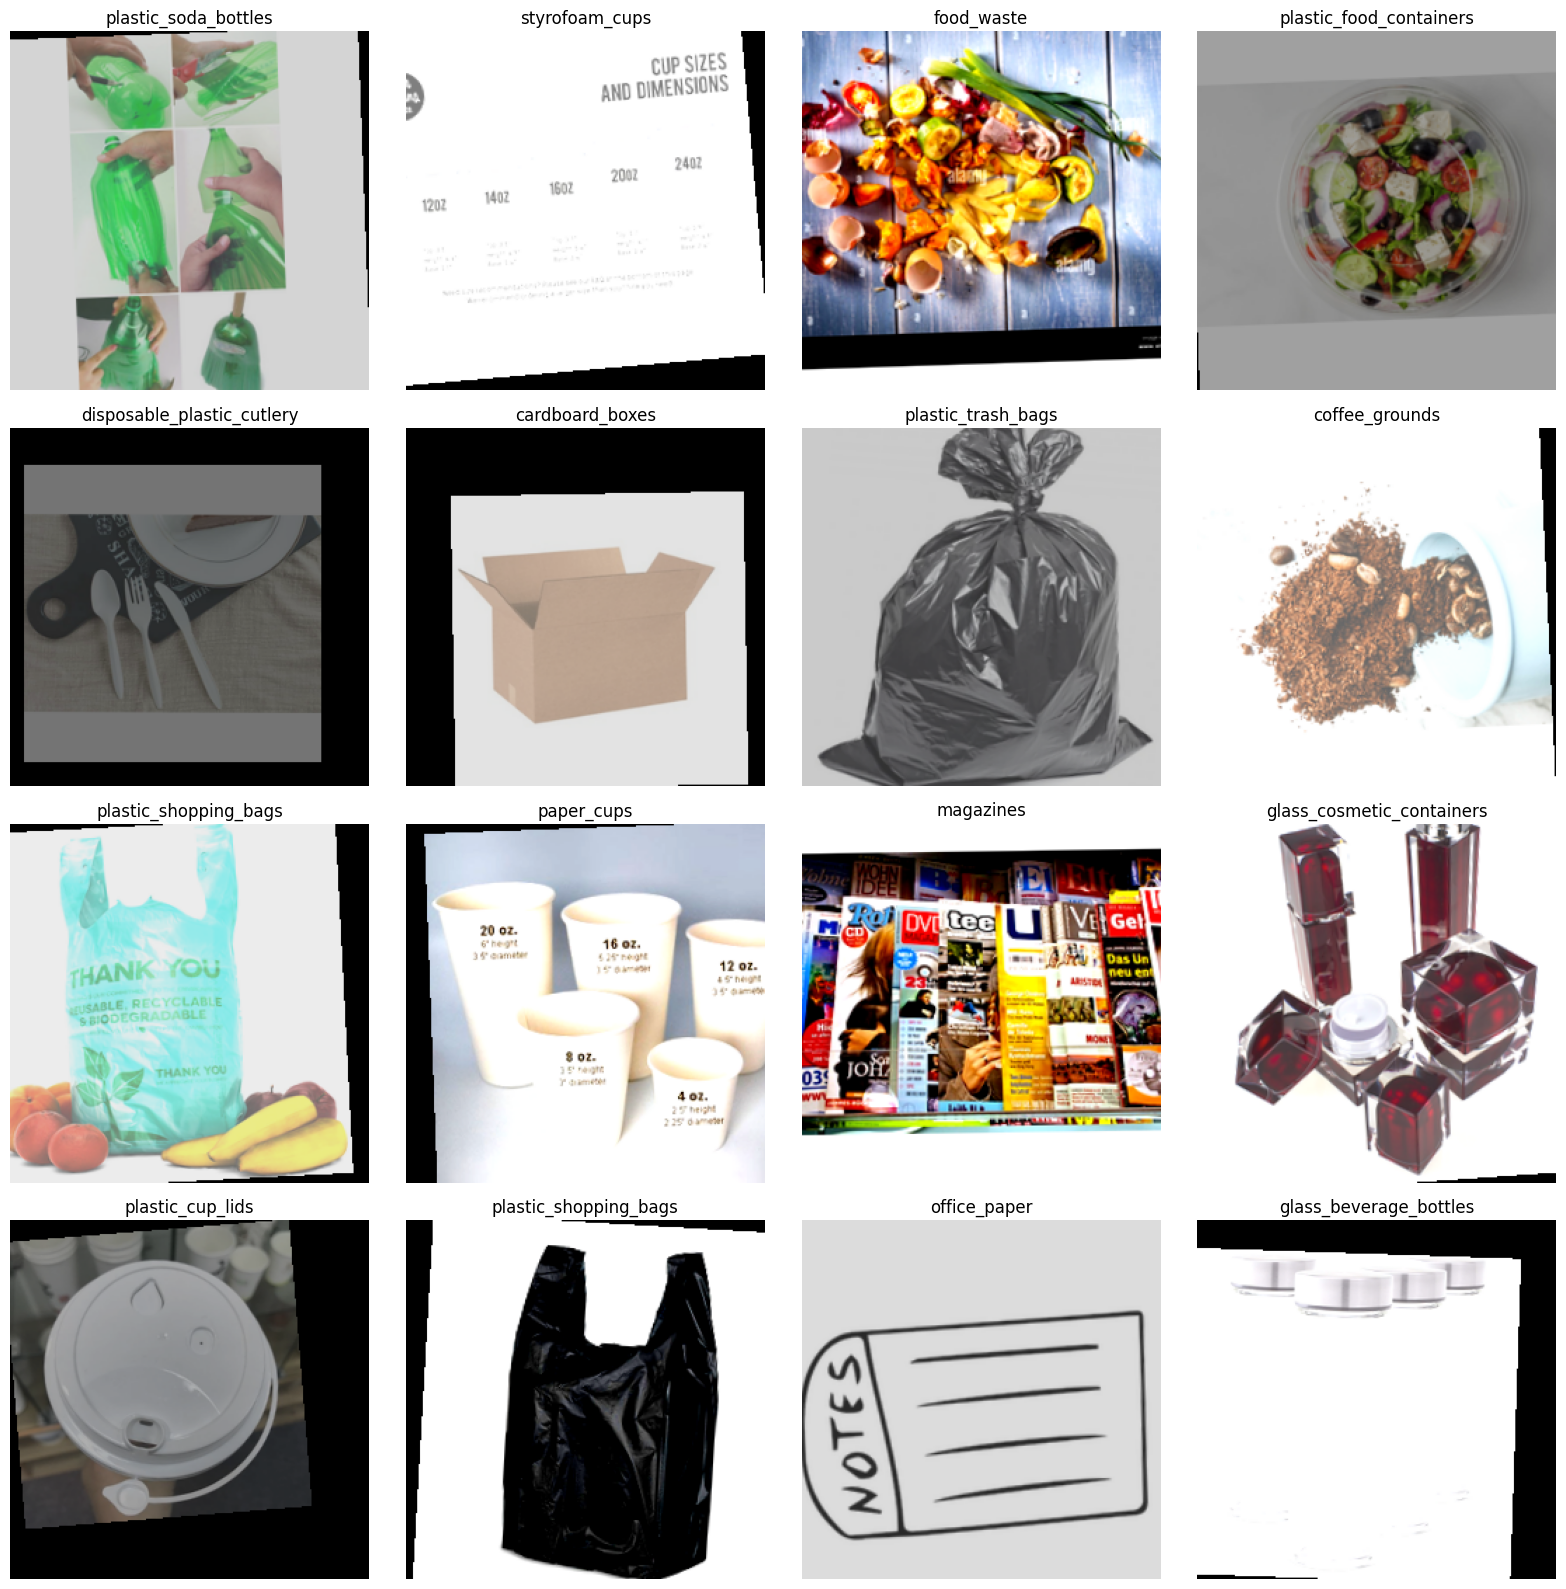

In [7]:
def visualize_batch(batch, classes, dataset_type):
    # initialize a figure
    fig = plt.figure("{} batch".format(dataset_type),
                     figsize=(batch_size, batch_size))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    # loop over the batch size
    for i in range(0, batch_size):
        # create a subplot with 4x8
        ax = plt.subplot(4, 4, i + 1)
        # grab the image, convert it from channels first ordering to
        # channels last ordering, and scale the raw pixel intensities
        # to the range [0, 255]
        image = batch["image"][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = std * image + mean
        image = image.astype("uint8")
        # grab the label id and get the label from the classes list
        idx = batch["label"][i]
        label = classes[idx]
        # show the image along with the label
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
    # show the plot
    plt.tight_layout()
    plt.show()

#visualize train data
train_batch = next(iter(data_loaders["train"]))
visualize_batch(train_batch,class_names,"train")

# Custom Waste Classification Model

In [8]:
class WasteClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobnet = mobilenet_v3_small(weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        train_nodes, eval_nodes = get_graph_node_names(self.mobnet)
        self.feature_extraction = create_feature_extractor(self.mobnet,return_nodes={'features.12': 'mob_feature'})
        self.conv1 = nn.Conv2d(576,300,3)
        #self.conv2 = nn.Conv2d(300,150, 3)
        self.fc1 = nn.Linear(10800,30)
        #self.fc2 = nn.Linear(1000, 30)
        self.dr = nn.Dropout()

    def forward(self,x):
        feature_layer = self.feature_extraction(x)['mob_feature']
        x = F.relu(self.conv1(feature_layer))
        #x = F.relu(self.conv2(x))
        x = x.flatten(start_dim=1)
        x = self.dr(x)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        output = self.fc1(x)
        return output

# Model Training

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using Device {device}")

#Prepare Criterion and Optimizer
model = WasteClassificationModel()
model = model.to(device)
criterian = nn.CrossEntropyLoss()
model_optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

best_acc = {"train":-1000,
            "val":-1000}
best_loss = {"train":1000,
             "val":1000}

best_accuracy_model_path = {
    "train":os.path.join("/kaggle/working/","train_acc_best.pt"),
    "val":os.path.join("/kaggle/working/","val_acc_best.pt")
}
best_loss_model_path = {
    "train": os.path.join("/kaggle/working/", "train_loss_best.pt"),
    "val": os.path.join("/kaggle/working/", "val_loss_best.pt")
}

for epoch in range(num_epochs):

    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ["train", "val"]:
        if phase=="train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0.0

        for idx, data in enumerate(data_loaders[phase]):

            inputs, labels = data["image"].to(device), data["label"].to(device)

            model_optimizer.zero_grad()


            with torch.set_grad_enabled(phase=="train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterian(outputs, labels)


                if phase=="train":
                    loss.backward()
                    model_optimizer.step()

            ## statitics
            running_loss+=loss.item()*inputs.size(0)
            running_corrects+=torch.sum(preds==labels.data)

        # if phase=="train":
        #     scheduler.step()

        epoch_loss = running_loss/dataset_sizes[phase]
        epoch_acc = running_corrects/dataset_sizes[phase]

        print(f"{phase} Loss : {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        #deep copy the model
        if epoch_acc>best_acc[phase]:
            best_acc[phase] = epoch_acc
            torch.save({
             'epoch':idx,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':model_optimizer.state_dict(),
                'loss':running_loss
            },best_accuracy_model_path[phase])

        if epoch_loss < best_loss[phase]:
            best_loss[phase] = epoch_loss
            torch.save({
                'epoch': idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': model_optimizer.state_dict(),
                'loss': running_loss
            }, best_loss_model_path[phase])





Using Device cuda:0
Epoch 0/49
----------
train Loss : 2.4277 Acc: 0.3424
val Loss : 1.8508 Acc: 0.4863
Epoch 1/49
----------
train Loss : 1.9196 Acc: 0.4673
val Loss : 1.5361 Acc: 0.5590
Epoch 2/49
----------
train Loss : 1.6796 Acc: 0.5256
val Loss : 1.3097 Acc: 0.6023
Epoch 3/49
----------
train Loss : 1.5495 Acc: 0.5616
val Loss : 1.0460 Acc: 0.6770
Epoch 4/49
----------
train Loss : 1.4496 Acc: 0.5858
val Loss : 1.0561 Acc: 0.6843
Epoch 5/49
----------
train Loss : 1.3724 Acc: 0.6064
val Loss : 1.2984 Acc: 0.6217
Epoch 6/49
----------
train Loss : 1.3211 Acc: 0.6266
val Loss : 0.9957 Acc: 0.7030
Epoch 7/49
----------
train Loss : 1.2918 Acc: 0.6362
val Loss : 1.0707 Acc: 0.6937
Epoch 8/49
----------
train Loss : 1.2351 Acc: 0.6513
val Loss : 1.0657 Acc: 0.6837
Epoch 9/49
----------
train Loss : 1.1696 Acc: 0.6651
val Loss : 0.8950 Acc: 0.7490
Epoch 10/49
----------
train Loss : 1.1792 Acc: 0.6674
val Loss : 0.9496 Acc: 0.7173
Epoch 11/49
----------
train Loss : 1.1462 Acc: 0.6716


# Accuracy of Validation Data


-------Classification Report-------

                            precision    recall  f1-score   support

              aerosol_cans       0.90      0.90      0.90       100
        aluminum_food_cans       0.50      0.51      0.50       100
        aluminum_soda_cans       0.84      0.68      0.75       100
           cardboard_boxes       0.53      0.81      0.64       100
       cardboard_packaging       0.51      0.28      0.36       100
                  clothing       0.93      0.81      0.87       100
            coffee_grounds       0.92      0.97      0.95       100
disposable_plastic_cutlery       0.99      0.79      0.88       100
                 eggshells       1.00      0.72      0.84       100
                food_waste       0.98      0.87      0.92       100
    glass_beverage_bottles       0.91      0.82      0.86       100
 glass_cosmetic_containers       0.82      0.96      0.88       100
           glass_food_jars       0.89      0.91      0.90       100
         

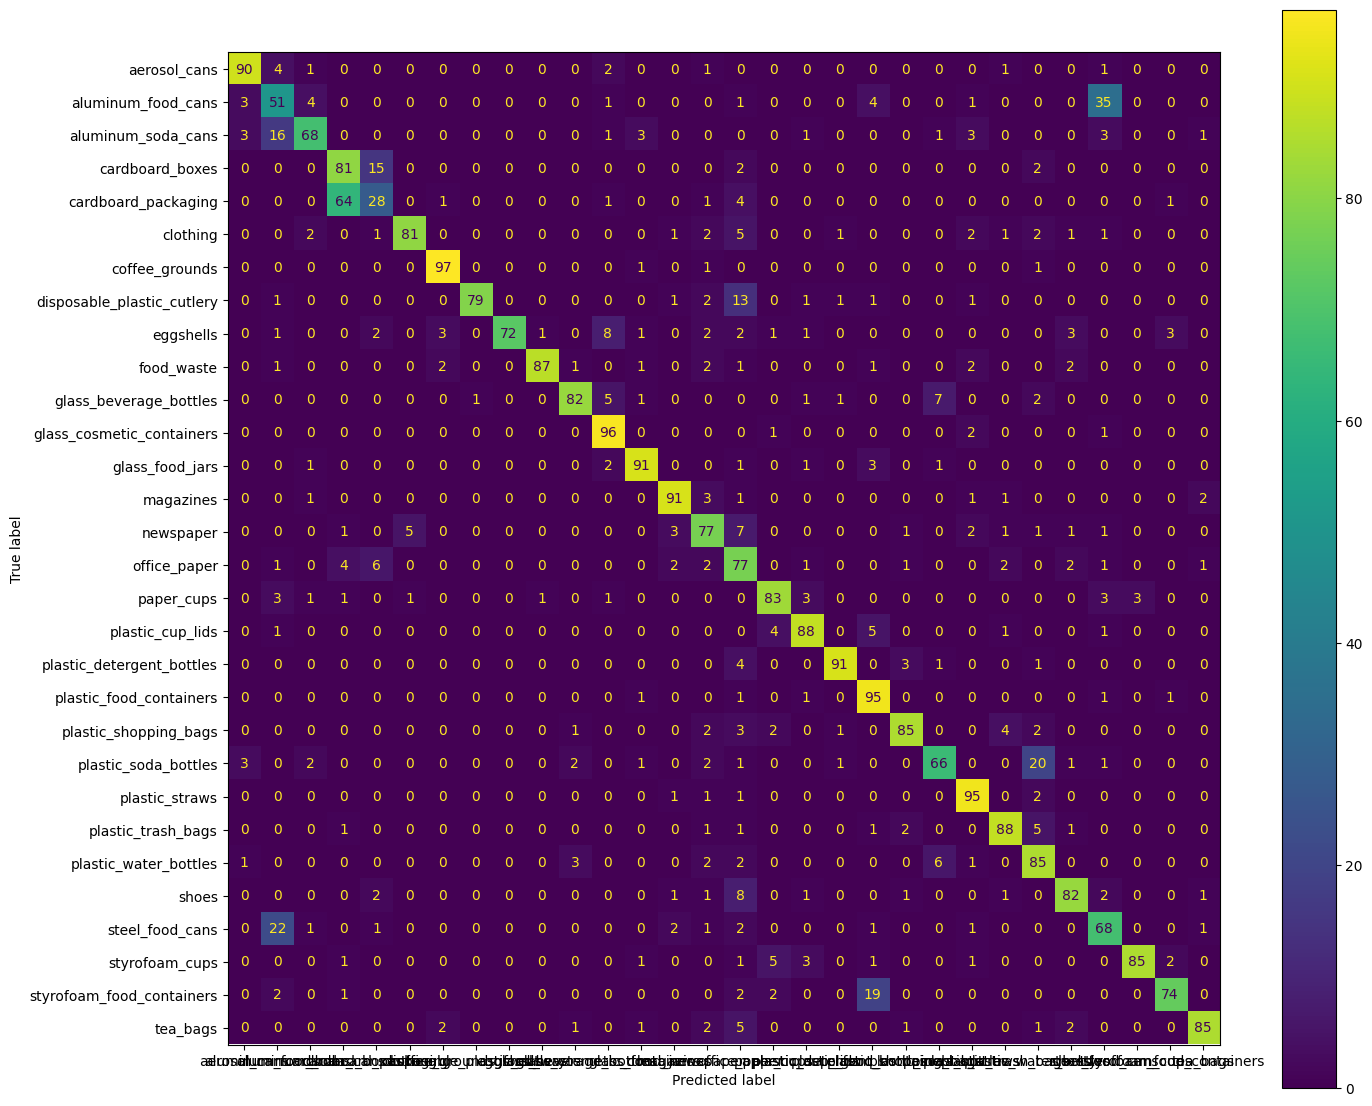

In [11]:
model = WasteClassificationModel()
checkpoint = torch.load("/kaggle/working/train_loss_best.pt")
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

data_size = len(image_datasets["val"])
y_preds = []
y_true = []

for idx, data in enumerate(data_loaders["val"]):
    inputs, labels = data["image"].to(device), data["label"].to(device)

    outputs = model(inputs)
    _, predictions = torch.max(outputs,1)
    y_preds.extend(predictions.cpu().numpy().tolist())
    y_true.extend(labels.cpu().numpy().tolist())

print("\n-------Classification Report-------\n")
print(classification_report(y_true, y_preds,target_names=class_names))
cm = confusion_matrix(y_true, y_preds)
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
fig, ax = plt.subplots(figsize=(16,14))
cm_disp.plot(ax=ax)



# Prediction on Sample Test Data

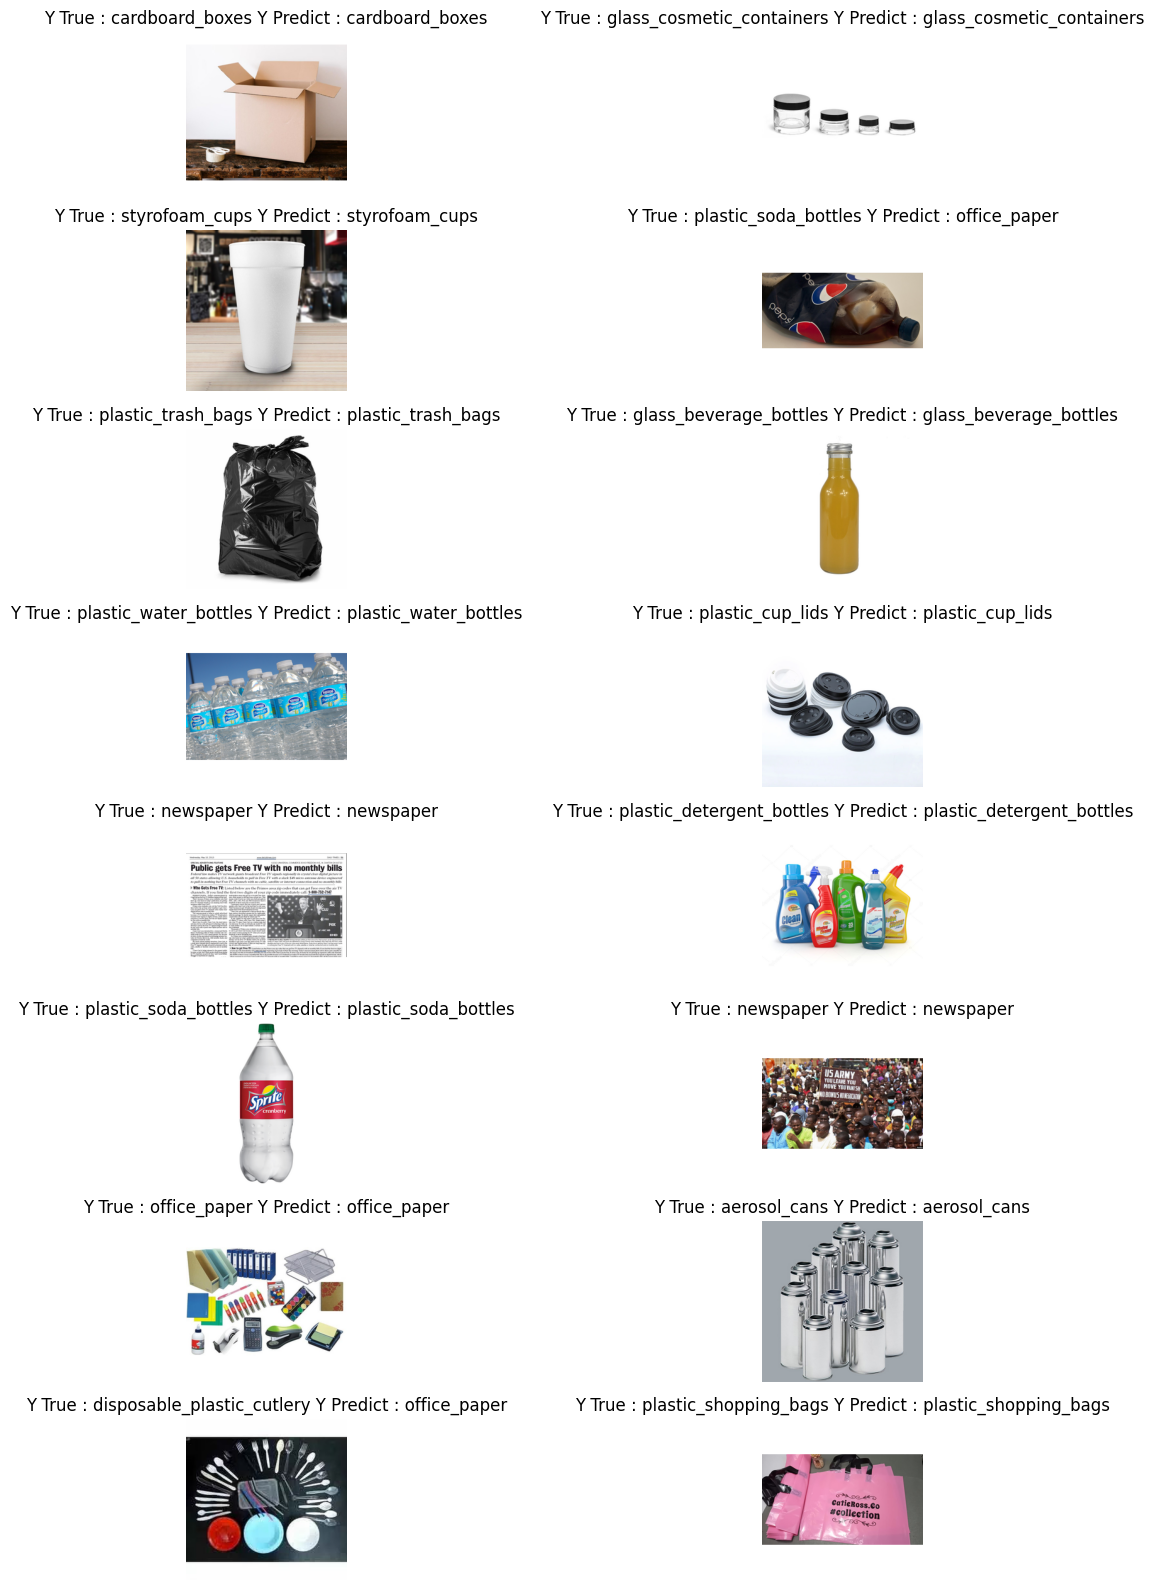

In [13]:
test_batch = next(iter(data_loaders["test"]))
inputs, labels = test_batch["image"].to(device), test_batch["label"].to(device)
outputs = model(inputs)
_, predictions = torch.max(outputs.data,1)


fig = plt.figure("Test Batch",
                     figsize=(batch_size, batch_size))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
# loop over the batch size
for i in range(len(predictions)):
    # create a subplot with 4x4
    ax = plt.subplot(8, 2, i + 1)
    # grab the image, convert it from channels first ordering to
    # channels last ordering, and scale the raw pixel intensities
    # to the range [0, 255]
    image = inputs[i].cpu().numpy()
    image = image.transpose((1, 2, 0))
    image = std * image + mean
    image = image.astype("uint8")
    # grab the label id and get the label from the classes list
    idx = labels[i]
    true_label = class_names[idx]
    predicted_label = class_names[predictions[i]]
    # show the image along with the label
    plt.imshow(image)
    title_label = "Y True : {} Y Predict : {}".format(true_label,predicted_label)
    plt.title(title_label)
    plt.axis("off")
# show the plot
plt.tight_layout()
plt.show()

